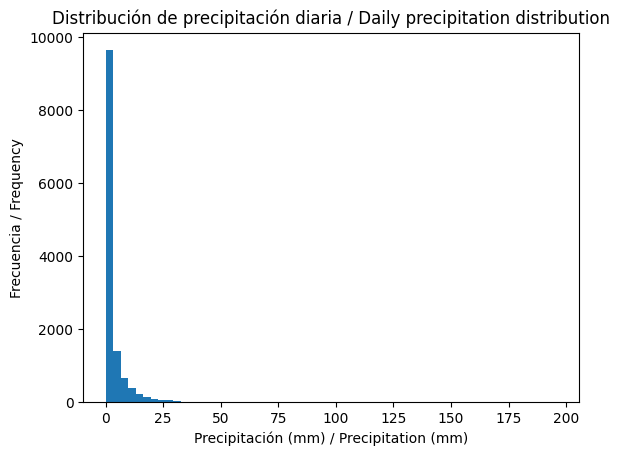

Share of zero-precip days / Proporción de días con 0 mm: 0.316


,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,relative_humidity_2m_mean,surface_pressure_mean,wind_speed_10m_mean,cloud_cover_mean,date,temp_range,doy_sin,doy_cos,precip_lag_1,precip_lag_3,precip_lag_7,precip_roll_3,precip_roll_7
0,1990-01-01,27.4,22.2,24.0,0.0,81,1018.1,13.2,19,1990-01-01,5.2,0.017213,0.999852,NaN,NaN,NaN,NaN,NaN
1,1990-01-02,24.4,20.5,21.8,0.0,71,1022.1,24.1,68,1990-01-02,3.9,0.034422,0.999407,0.0,NaN,NaN,NaN,NaN
2,1990-01-03,24.4,21.0,22.3,0.1,72,1022.7,21.8,56,1990-01-03,3.4,0.051620,0.998667,0.0,NaN,NaN,0.1,NaN
3,1990-01-04,25.3,23.0,23.9,0.7,77,1021.1,24.0,56,1990-01-04,2.3,0.068802,0.997630,0.1,0.0,NaN,0.8,NaN
4,1990-01-05,25.9,23.3,24.2,0.7,83,1019.7,19.1,33,1990-01-05,2.6,0.085965,0.996298,0.7,0.0,NaN,1.5,NaN


In [6]:
""" 
03 - Modeling (Regression) with Feature Ablation

Goal
----
Predict daily precipitation (precipitation_sum) for Miami using Open-Meteo daily data.
Run feature ablation experiments to quantify the signal contribution of:
A) Base physical variables
B) Seasonality (cyclical day-of-year)
C) Memory (lags/rolling of precipitation)

Notes
-----
- Code and comments are in English.
- Plot titles/labels include Spanish + English.
- We enforce temporal splits (no shuffling) to avoid leakage.

Expected input
--------------
data/raw/open_meteo_miami_daily.csv

Outputs
-------
- data/processed/ablation_results.csv
- data/processed/predictions_best_experiment.csv
"""

# %%
# =========================
# Imports
# =========================

import sys
from pathlib import Path
from __future__ import annotations



from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Local feature engineering
from src.features import (
    build_base_features,
    build_seasonal_features,
    build_memory_features,
    ensure_sorted_by_date,
)


# %%
# =========================
# Config
# =========================
PROJECT_ROOT = Path.cwd().parents[0]   # notebooks/ -> project root
sys.path.append(str(PROJECT_ROOT))
RAW_PATH = PROJECT_ROOT / "data" / "raw" / "open_meteo_miami_daily.csv"
OUT_DIR = PROJECT_ROOT / "data" / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET = "precipitation_sum"
DATE_COL = "date"

# Temporal split (no shuffle): last 20% as test
TEST_FRACTION = 0.20

# If True, model log(1 + precip) to reduce skew; metrics reported on original scale.
USE_LOG_TARGET = False

RANDOM_STATE = 42


# %%
# =========================
# Load data
# =========================

if not RAW_PATH.exists():
    raise FileNotFoundError(
        f"Raw dataset not found at: {RAW_PATH}. "
        "Run the Open-Meteo ingestion script first."
    )

raw = pd.read_csv(RAW_PATH)

# Enforce date parsing
raw[DATE_COL] = pd.to_datetime(raw[DATE_COL])
raw = ensure_sorted_by_date(raw, date_col=DATE_COL)

# Basic sanity checks
required_cols = {
    DATE_COL,
    TARGET,
    "temperature_2m_max",
    "temperature_2m_min",
    "temperature_2m_mean",
    "relative_humidity_2m_mean",
    "surface_pressure_mean",
    "wind_speed_10m_mean",
    "cloud_cover_mean",
}
missing = sorted(list(required_cols - set(raw.columns)))
if missing:
    raise RuntimeError(f"Missing required columns in raw dataset: {missing}")

raw.head()


# %%
# =========================
# Quick target diagnostics
# =========================

fig = plt.figure()
plt.hist(raw[TARGET].values, bins=60)
plt.title("Distribución de precipitación diaria / Daily precipitation distribution")
plt.xlabel("Precipitación (mm) / Precipitation (mm)")
plt.ylabel("Frecuencia / Frequency")
plt.show()

zero_rate = (raw[TARGET] == 0).mean()
print(f"Share of zero-precip days / Proporción de días con 0 mm: {zero_rate:.3f}")


# %%
# =========================
# Feature groups (definitions)
# =========================

# Base physical variables (A)
BASE_FEATURES = [
    "temperature_2m_mean",
    "relative_humidity_2m_mean",
    "cloud_cover_mean",
    "surface_pressure_mean",
    "wind_speed_10m_mean",
    "temp_range",  # engineered but still physical: max - min
]

# Seasonality (B)
SEASONAL_FEATURES = [
    "doy_sin",
    "doy_cos",
]

# Memory (C)
MEMORY_FEATURES = [
    "precip_lag_1",
    "precip_lag_3",
    "precip_lag_7",
    "precip_roll_3",
    "precip_roll_7",
]


# %%
# =========================
# Build feature-enriched master table
# =========================

# 1) Add base physical engineered features
feat = build_base_features(raw)

# 2) Add seasonal cyclical encoding
feat = build_seasonal_features(feat)

# 3) Add precipitation memory features (lags + rolling)
feat = build_memory_features(feat)

# Keep only numeric features + date + target for modeling convenience
feat = ensure_sorted_by_date(feat, date_col=DATE_COL)
feat.head()


In [7]:
# %%
# =========================
# Train/test split (temporal)
# =========================

n = len(feat)
split_idx = int(np.floor((1.0 - TEST_FRACTION) * n))

train_df = feat.iloc[:split_idx].copy()
test_df = feat.iloc[split_idx:].copy()

print(
    "Train period / Período train:",
    train_df[DATE_COL].min().date(),
    "→",
    train_df[DATE_COL].max().date(),
)
print(
    "Test period / Período test:",
    test_df[DATE_COL].min().date(),
    "→",
    test_df[DATE_COL].max().date(),
)


# %%
# =========================
# Experiment definitions (feature ablation)
# =========================

@dataclass(frozen=True)
class Experiment:
    name: str
    feature_list: List[str]
    notes: str


def make_experiments() -> List[Experiment]:
    """Create the ablation experiment list."""

    # A) Base only
    exp1 = Experiment(
        name="EXP1_base",
        feature_list=BASE_FEATURES,
        notes="Only physical state variables / Solo variables físicas",
    )

    # A + B
    exp2 = Experiment(
        name="EXP2_base_season",
        feature_list=BASE_FEATURES + SEASONAL_FEATURES,
        notes="Physical + annual cycle / Física + estacionalidad",
    )

    # C only
    exp3 = Experiment(
        name="EXP3_memory",
        feature_list=MEMORY_FEATURES,
        notes="Only precipitation persistence / Solo persistencia",
    )

    # B + C
    exp4 = Experiment(
        name="EXP4_season_memory",
        feature_list=SEASONAL_FEATURES + MEMORY_FEATURES,
        notes="Annual cycle + persistence / Estacionalidad + persistencia",
    )

    # A + C
    exp5 = Experiment(
        name="EXP5_base_memory",
        feature_list=BASE_FEATURES + MEMORY_FEATURES,
        notes="Physical + persistence / Física + persistencia",
    )

    # A + B + C (full)
    exp6 = Experiment(
        name="EXP6_full",
        feature_list=BASE_FEATURES + SEASONAL_FEATURES + MEMORY_FEATURES,
        notes="Full model / Modelo completo",
    )

    # Internal ablation: lags-only vs roll-only (with A+B)
    exp7 = Experiment(
        name="EXP7_full_lags_only",
        feature_list=BASE_FEATURES + SEASONAL_FEATURES + [
            "precip_lag_1",
            "precip_lag_7",
        ],
        notes="A+B + lags only / A+B + solo lags",
    )

    exp8 = Experiment(
        name="EXP8_full_roll_only",
        feature_list=BASE_FEATURES + SEASONAL_FEATURES + [
            "precip_roll_7",
        ],
        notes="A+B + roll only / A+B + solo rolling",
    )

    return [exp1, exp2, exp3, exp4, exp5, exp6, exp7, exp8]


EXPERIMENTS = make_experiments()
len(EXPERIMENTS), [e.name for e in EXPERIMENTS]


# %%
# =========================
# Models
# =========================

MODELS: Dict[str, object] = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "Lasso": Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=50_000),
    "RandomForest": RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
}


# %%
# =========================
# Helpers: dataset build, training, evaluation
# =========================


def prepare_xy(
    train: pd.DataFrame,
    test: pd.DataFrame,
    features: List[str],
    target: str,
    use_log_target: bool,
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """Prepare X/y for train/test with dropna applied consistently."""

    needed = [DATE_COL] + features + [target]

    train_sub = train[needed].dropna().copy()
    test_sub = test[needed].dropna().copy()

    X_train = train_sub[features]
    y_train = train_sub[target]
    X_test = test_sub[features]
    y_test = test_sub[target]

    if use_log_target:
        y_train = np.log1p(y_train)
        y_test = np.log1p(y_test)

    return X_train, y_train, X_test, y_test



def inverse_target(y: np.ndarray | pd.Series, use_log_target: bool) -> np.ndarray:
    """Invert log1p transform back to mm scale."""

    y_arr = np.asarray(y)
    if use_log_target:
        return np.expm1(y_arr)
    return y_arr



def evaluate_regression(y_true_mm: np.ndarray, y_pred_mm: np.ndarray) -> Dict[str, float]:
    """Compute MAE, RMSE, R2 on original precipitation scale (mm)."""

    mae = mean_absolute_error(y_true_mm, y_pred_mm)
    rmse = np.sqrt(mean_squared_error(y_true_mm, y_pred_mm))
    r2 = r2_score(y_true_mm, y_pred_mm)

    return {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}


# %%
# =========================
# Run ablation grid
# =========================

results_rows: List[Dict[str, object]] = []
predictions_store: Dict[Tuple[str, str], pd.DataFrame] = {}

for exp in EXPERIMENTS:
    for model_name, model in MODELS.items():

        X_train, y_train, X_test, y_test = prepare_xy(
            train_df,
            test_df,
            exp.feature_list,
            TARGET,
            USE_LOG_TARGET,
        )

        # Fit
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Bring to original mm scale
        y_true_mm = inverse_target(y_test, USE_LOG_TARGET)
        y_pred_mm = inverse_target(y_pred, USE_LOG_TARGET)

        metrics = evaluate_regression(y_true_mm, y_pred_mm)

        row = {
            "experiment": exp.name,
            "model": model_name,
            "n_train": int(len(X_train)),
            "n_test": int(len(X_test)),
            "features": ",".join(exp.feature_list),
            "notes": exp.notes,
            "use_log_target": USE_LOG_TARGET,
            **metrics,
        }
        results_rows.append(row)

        # Store predictions for later inspection
        preds_df = test_df[[DATE_COL]].copy()
        preds_df = preds_df.loc[test_df.index.isin(X_test.index)].copy()
        preds_df["y_true_mm"] = y_true_mm
        preds_df["y_pred_mm"] = y_pred_mm

        predictions_store[(exp.name, model_name)] = preds_df

results = pd.DataFrame(results_rows)
results.sort_values(["RMSE", "MAE"]).head(10)


# %%
# =========================
# Save results
# =========================

results_path = OUT_DIR / "ablation_results.csv"
results.to_csv(results_path, index=False)
print(f"[SAVE] Ablation results -> {results_path}")



Train period / Período train: 1990-01-01 → 2017-12-31
Test period / Período test: 2018-01-01 → 2024-12-31
[SAVE] Ablation results -> /Users/alejandroagusti/Documents/GitHub/Weather-ds-portfolio/data/processed/ablation_results.csv


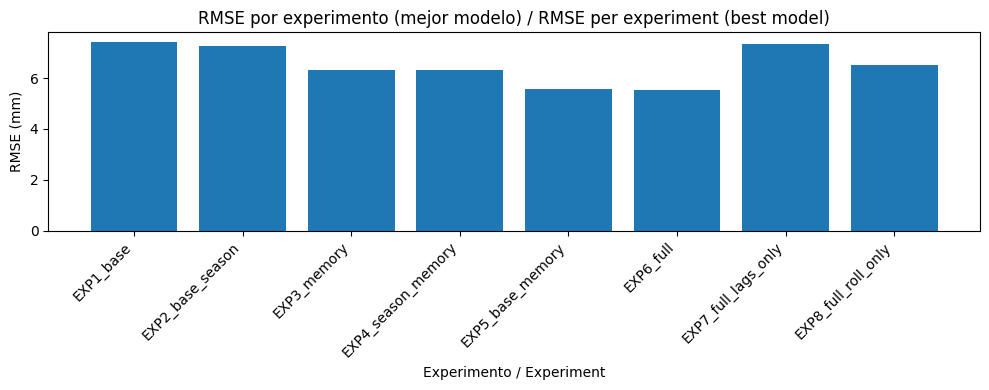

In [8]:
# %%
# =========================
# Compare experiments visually (best per experiment)
# =========================

# Pick the best model per experiment by RMSE
best_per_exp = (
    results.sort_values(["experiment", "RMSE", "MAE"]).groupby("experiment").head(1)
).reset_index(drop=True)

best_per_exp


# %%
# Bar plot of RMSE per experiment (best model)

fig = plt.figure(figsize=(10, 4))
plt.bar(best_per_exp["experiment"], best_per_exp["RMSE"].values)
plt.xticks(rotation=45, ha="right")
plt.title("RMSE por experimento (mejor modelo) / RMSE per experiment (best model)")
plt.ylabel("RMSE (mm)")
plt.xlabel("Experimento / Experiment")
plt.tight_layout()
plt.show()

In [9]:
# %%
# =========================
# Inspect the overall best run (by RMSE)
# =========================

best_row = results.sort_values(["RMSE", "MAE"]).iloc[0]
best_exp = best_row["experiment"]
best_model = best_row["model"]

print("Best run / Mejor corrida:")
print(best_row[["experiment", "model", "MAE", "RMSE", "R2"]])

preds_best = predictions_store[(best_exp, best_model)].copy()

# Save predictions
pred_path = OUT_DIR / "predictions_best_experiment.csv"
preds_best.to_csv(pred_path, index=False)
print(f"[SAVE] Best predictions -> {pred_path}")

Best run / Mejor corrida:
experiment       EXP6_full
model         RandomForest
MAE               2.113122
RMSE              5.550006
R2                0.666082
Name: 23, dtype: object
[SAVE] Best predictions -> /Users/alejandroagusti/Documents/GitHub/Weather-ds-portfolio/data/processed/predictions_best_experiment.csv


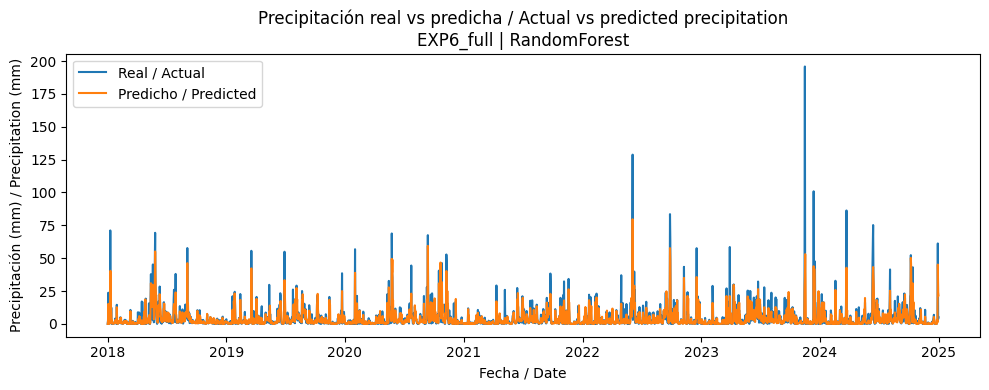

In [10]:
# %%
# Plot: true vs predicted (best)

fig = plt.figure(figsize=(10, 4))
plt.plot(preds_best[DATE_COL], preds_best["y_true_mm"].values, label="Real / Actual")
plt.plot(preds_best[DATE_COL], preds_best["y_pred_mm"].values, label="Predicho / Predicted")
plt.title(
    f"Precipitación real vs predicha / Actual vs predicted precipitation\n{best_exp} | {best_model}"
)
plt.xlabel("Fecha / Date")
plt.ylabel("Precipitación (mm) / Precipitation (mm)")
plt.legend()
plt.tight_layout()
plt.show()

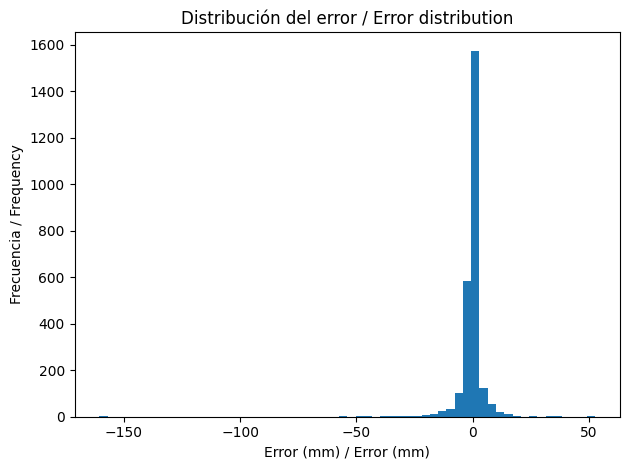

In [11]:
# %%
# =========================
# Optional: error distribution (best)
# =========================

errors = preds_best["y_pred_mm"].values - preds_best["y_true_mm"].values

fig = plt.figure()
plt.hist(errors, bins=60)
plt.title("Distribución del error / Error distribution")
plt.xlabel("Error (mm) / Error (mm)")
plt.ylabel("Frecuencia / Frequency")
plt.tight_layout()
plt.show()

In [12]:
# %%
# =========================
# Next steps (notes)
# =========================

print(
    "\nNext steps / Próximos pasos:\n"
    "1) If the model underpredicts spikes, consider log target (USE_LOG_TARGET=True) or a two-stage model.\n"
    "2) Try classification (rain/no-rain) + regression for positive-rain days.\n"
    "3) Add physically motivated interactions (e.g., humidity x cloud cover) and evaluate ablation again.\n"
)


Next steps / Próximos pasos:
1) If the model underpredicts spikes, consider log target (USE_LOG_TARGET=True) or a two-stage model.
2) Try classification (rain/no-rain) + regression for positive-rain days.
3) Add physically motivated interactions (e.g., humidity x cloud cover) and evaluate ablation again.



Conclusions – Feature Engineering & Modeling (EN / ES)

Conclusions (English)

This feature engineering and modeling exercise shows that daily precipitation is best explained by a combination of physical state, seasonality, and atmospheric memory.

Models relying solely on instantaneous atmospheric variables (temperature, humidity, pressure, wind) or seasonal proxies perform poorly. In contrast, features that encode temporal persistence—such as lagged precipitation and rolling accumulations—provide a substantial improvement in predictive skill, confirming the importance of atmospheric memory in precipitation processes.

The best-performing experiment (EXP6_full), combining base variables, seasonal features, and memory features, achieved an R² of approximately 0.66, which is strong for daily precipitation modeling given the highly skewed and intermittent nature of rainfall. Error analysis shows that predictions are generally accurate for low to moderate precipitation but tend to underestimate extreme rainfall events, a known and expected limitation when modeling rare convective extremes with standard regression objectives.

Overall, the results demonstrate that physically motivated feature engineering, combined with non-linear models such as Random Forests, can capture a significant portion of daily precipitation variability without relying on high-resolution or mesoscale predictors.

⸻

Conclusiones (Español)

Este ejercicio de feature engineering y modelado muestra que la precipitación diaria se explica mejor mediante una combinación de estado físico atmosférico, estacionalidad y memoria atmosférica.

Los modelos que utilizan únicamente variables instantáneas (temperatura, humedad, presión, viento) o proxies estacionales presentan un desempeño limitado. En cambio, las variables que incorporan persistencia temporal, como retardos de precipitación y acumulados móviles, mejoran significativamente la capacidad predictiva, confirmando el rol clave de la memoria atmosférica en los procesos de precipitación.

El mejor experimento (EXP6_full), que combina variables base, estacionales y de memoria, alcanzó un R² cercano a 0.66, un valor elevado para precipitación diaria dada su distribución altamente asimétrica y episódica. El análisis de errores indica buen desempeño en precipitaciones bajas y moderadas, con una subestimación sistemática de eventos extremos, una limitación esperable al modelar fenómenos raros mediante enfoques de regresión estándar.

En conjunto, los resultados demuestran que un feature engineering con criterio físico, junto con modelos no lineales como Random Forest, permite capturar una parte sustancial de la variabilidad diaria de la precipitación sin necesidad de información de mesoescala o alta resolución.